<a href="https://colab.research.google.com/github/aminik/projects_GoogleColab/blob/main/model_nn_transaction_huggingface_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Field preporation

In [47]:
for lib_name in  ["tensorflow" ,"transformers", "torch", "evaluate", "requests"]:
  !pip list | grep -i {lib_name}

tensorflow                         2.17.1
tensorflow-datasets                4.9.7
tensorflow-hub                     0.16.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.13.1
tensorflow-probability             0.24.0
sentence-transformers              3.3.1
transformers                       4.47.1
torch                              2.5.1+cu121
torchaudio                         2.5.1+cu121
torchsummary                       1.5.1
torchvision                        0.20.1+cu121
evaluate                           0.4.3
requests                           2.32.3
requests-oauthlib                  1.3.1
requests-toolbelt                  1.0.0


not exists library evalute

In [5]:
## connect to GoogleDrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### LIBS

Для доступа к моделям есть два способа:

Прямое использование моделей на исходном фреймворке — больше кода, но и больше гибкости.

Класс Pipeline — самый простой способ воспользоваться моделями из transformers. С него и начнем.

In [9]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [6]:
import transformers
import evaluate

# all metrcics takes from https://huggingface.co/evaluate-metric

# from transformers import pipeline

In [28]:
for mtrc in evaluate.list_evaluation_modules():
  if mtrc.find('f1') != -1:
    print(mtrc)

In [24]:
mtrc.find('f1')

-1

In [34]:
# https://huggingface.co/spaces/evaluate-metric/f1
mtrc_f1 = evaluate.load(path='f1') #evaluate.load(module_name='f1')

Для доступа к моделям есть два способа:

- Прямое использование моделей на исходном фреймворке — больше кода, но и больше гибкости.

- Класс Pipeline — самый простой способ воспользоваться моделями из transformers. С него и начнем.

## ` Использование  модели  через класс  Pipeline`

In [40]:
from transformers import pipeline

In [44]:
hf_task = 'text-classification' # https://huggingface.co/tasks/text-classification
hf_model_name = 's-nlp/russian_toxicity_classifier' # https://huggingface.co/s-nlp/russian_toxicity_classifier
clf = pipeline( task = hf_task, model=hf_model_name,
               # можно добавить не родной токиназер
                tokenizer='bert-base-cased'
                )

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Device set to use cpu


In [45]:
text = ['У нас в есть убунты и текникал превью.',
    	'Как минимум два малолетних дегенерата в треде, мда.']

clf(text,
    #По умолчанию классификатор возвращает наиболее вероятный класс, но вы можете вернуть и все значения
		   top_k=None)

[[{'label': 'neutral', 'score': 0.9900795221328735},
  {'label': 'toxic', 'score': 0.00992051512002945}],
 [{'label': 'neutral', 'score': 0.9942336678504944},
  {'label': 'toxic', 'score': 0.005766342859715223}]]

 Что тут можно улучшить:

Помимо конкретной модели в pipeline можно передать tokenizer. Токенайзер используется в NLP задачах и отвечает за предварительную обработку текста и конвертирует их в массив чисел, которые затем поступают на вход модели (об этом подробнее ниже).

Обычно для модели используется точно такой же tokenizer, который использовался при обучении (только так можно гарантировать корректность ее работы). Но если по каким-либо причинам вам потребовался другой, то его можно задать примерно так:             
              

Если все данные, которые нужно обработать, не влазят в память, то можно задействовать генератор, который будет поштучно загружать данные в память и подавать их в модель:

In [ ]:
def data(text):
    for row in text:
        yield row

for out in clf(data(text)):
    print(out)

## ` Использование  модели  через PyTorch`

In [48]:
import torch
import requests
from PIL import Image
from io import BytesIO
from transformers import AutoImageProcessor, AutoModelForImageClassification


In [49]:
response = requests.get(
    'https://github.com/laxmimerit/dog-cat-full-dataset/blob/master/data/train/cats/cat.10055.jpg?raw=true')
img = Image.open(BytesIO(response.content))


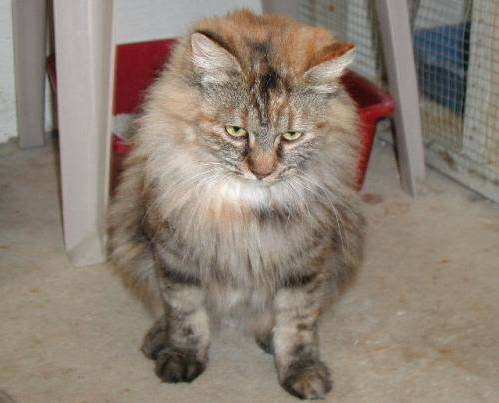

In [50]:
img

In [51]:
hf_model_name = 'google/vit-base-patch16-224'
# https://huggingface.co/google/vit-base-patch16-224
img_proc = AutoImageProcessor.from_pretrained(hf_model_name)
# ImageProcessor. Это аналог токенайзера, но только для картинок — выравнивает размеры картинок, нормализует и т.д. (об ImageProcessor чуть подробнее ниже).
# В предыдущем варианте предобработкой занимался сам Pipeline где-то в своих недрах. Сейчас же нам придется заниматься этим самостоятельно.
model = AutoModelForImageClassification.from_pretrained(hf_model_name)
# Сама модель представляет собой PyTorch nn.Module, который вы можете использовать как обычно при работе с торчом.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [52]:
# Обрабатываем картинку посредством ImageProcessor. ImageProcessor возвращает словарь, который подаем на вход модели с оператором распаковки (**).
inputs = img_proc(img, return_tensors='pt')


In [54]:
inputs

{'pixel_values': tensor([[[[ 0.4275,  0.4275,  0.4196,  ...,  0.0902,  0.1216,  0.0667],
          [ 0.4353,  0.4353,  0.4118,  ...,  0.0902,  0.0510,  0.0118],
          [ 0.4353,  0.4275,  0.4039,  ...,  0.1686,  0.1059,  0.0510],
          ...,
          [-0.1373, -0.0745, -0.0431,  ...,  0.2941,  0.2941,  0.2627],
          [-0.1529, -0.1137, -0.0588,  ...,  0.2784,  0.2706,  0.2627],
          [-0.1529, -0.1294, -0.0745,  ...,  0.2706,  0.2471,  0.2392]],

         [[ 0.4275,  0.4431,  0.4588,  ...,  0.0275,  0.0588,  0.0588],
          [ 0.4431,  0.4510,  0.4510,  ...,  0.0275, -0.0039,  0.0039],
          [ 0.4431,  0.4431,  0.4431,  ...,  0.1059,  0.0431,  0.0275],
          ...,
          [-0.2392, -0.1765, -0.1451,  ...,  0.1922,  0.1922,  0.1765],
          [-0.2549, -0.2157, -0.1608,  ...,  0.1765,  0.1765,  0.1922],
          [-0.2549, -0.2314, -0.1765,  ...,  0.1686,  0.1529,  0.1765]],

         [[ 0.4431,  0.4510,  0.4275,  ..., -0.0902, -0.0745, -0.0980],
          [ 0

In [55]:
# словарь, который подаем на вход модели с оператором распаковки (**).
# Transformers возвращают логиты, которые идут перед последней функцией активации (например, softmax). Соответственно, нам самим необходимо их обработать, чтобы получить на выходе вероятность или класс.
with torch.no_grad():
    logits = model(**inputs).logits


In [59]:
{each : model.config.id2label[each] for  each in  model.config.id2label.keys() if each <5}

{0: 'tench, Tinca tinca',
 1: 'goldfish, Carassius auratus',
 2: 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 3: 'tiger shark, Galeocerdo cuvieri',
 4: 'hammerhead, hammerhead shark'}

In [56]:

predicted_id = logits.argmax(-1).item()
predicted_label = model.config.id2label[predicted_id]
print(predicted_id, '-', predicted_label)


281 - tabby, tabby cat


Автоматическое определение архитектуры
Для каждой архитектуры и каждой задачи под нее есть свой специальный именной класс. Например: BertForSequenceClassification, GPT2ForSequenceClassification, RobertaForSequenceClassification и т.д. Также и для их предобработчиков: BertTokenizer, .GPT2Tokenizer и т.д.

Чтобы каждый раз не заморачиваться с определением точного названия класса в Transformers завезли так называемый AutoClass. AutoClass позволяет автоматически считывать всю метаинформацию (архитектуру и пр.) из предварительно обученной модели при ее загрузке:

In [ ]:
img_proc = AutoImageProcessor.from_pretrained(
    'google/vit-base-patch16-224')
model = AutoModelForImageClassification.from_pretrained(
    'google/vit-base-patch16-224')

tokenizer = AutoTokenizer.from_pretrained(
    'SkolkovoInstitute/russian_toxicity_classifier')
model = AutoModelForSequenceClassification.from_pretrained(
    'SkolkovoInstitute/russian_toxicity_classifier')

Каждый автокласс привязан к определенной задаче. С полным списком автоклассов можете ознакомится здесь: https://huggingface.co/docs/transformers/main/en/model_doc/auto

Если вы обучаете модель с нуля, то вам нужно импортировать точный конечный класс.

Дообучение
Не часто вам потребуются модели как есть. В соревнованиях, а тем более в работе вам скорее всего придется дообучить модель на своем датасете. И тут вас есть несколько вариантов…